In [34]:
# Ejecuta esto en una CELDA en Jupyter
%pip install --quiet pandas scikit-learn numpy matplotlib seaborn geopy folium tqdm plotly


Note: you may need to restart the kernel to use updated packages.


<h3>Cargar Dataset</h3>
<h5>120 años de Juegos Olímpicos</h5>

In [35]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import warnings
warnings.filterwarnings("ignore")

ruta = 'src/athlete_events.csv' #https://www.kaggle.com/datasets/heesoo37/120-years-of-olympic-history-athletes-and-results

print("Cargando dataset ...")
df = pd.read_csv(ruta)
print("Dataset cargado correctamente.")


Cargando dataset ...
Dataset cargado correctamente.


<h1>Análisis descriptivo</h1>

In [36]:
print(df.info())
print("\n", df.head(1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   39783 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB
None

    ID       Name Sex   Age  Height  Weight   Team  NOC        Games  Year  \
0   1  A Dijiang   M  24.0   180.0    80.0  China  CHN  1992 Summer  1992   

   Season       C

In [37]:
print(df.describe())

                  ID            Age         Height         Weight  \
count  271116.000000  261642.000000  210945.000000  208241.000000   
mean    68248.954396      25.556898     175.338970      70.702393   
std     39022.286345       6.393561      10.518462      14.348020   
min         1.000000      10.000000     127.000000      25.000000   
25%     34643.000000      21.000000     168.000000      60.000000   
50%     68205.000000      24.000000     175.000000      70.000000   
75%    102097.250000      28.000000     183.000000      79.000000   
max    135571.000000      97.000000     226.000000     214.000000   

                Year  
count  271116.000000  
mean     1978.378480  
std        29.877632  
min      1896.000000  
25%      1960.000000  
50%      1988.000000  
75%      2002.000000  
max      2016.000000  


<h3>Observamos el número de valores NULL por columna.</h3>

In [38]:
df.isnull().sum()

ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64

<h3>Eliminar NO DATA</h3>

Las columnas ['ID'] y ['Name'] no nos aportan nada.

La información de la columna ['Games'] la podemos sacar de ['Year'] y ['Season'].

La información de la columna ['Event'] la reducimos a la de la columna ['Sport'] para tener menos categorías.

Eliminamos la columna ['Team'] y nos quedamos con la columna ['NOC'] para no tener datos similares / duplicados.

In [39]:
df.drop(columns=["ID", "Name", "Games", "Event", "Team"], inplace=True)
print("\n", df.head(1))


   Sex   Age  Height  Weight  NOC  Year  Season       City       Sport Medal
0   M  24.0   180.0    80.0  CHN  1992  Summer  Barcelona  Basketball   NaN


<h3>Tratamiento de valores default</h3>
Pasamos los valores NaN a un valor default 'No Medal'

In [40]:
df['Medal'] = df['Medal'].fillna('No Medal')

<h1>Análisis univariante</h1>

<h3>Reparto de medallas</h3>

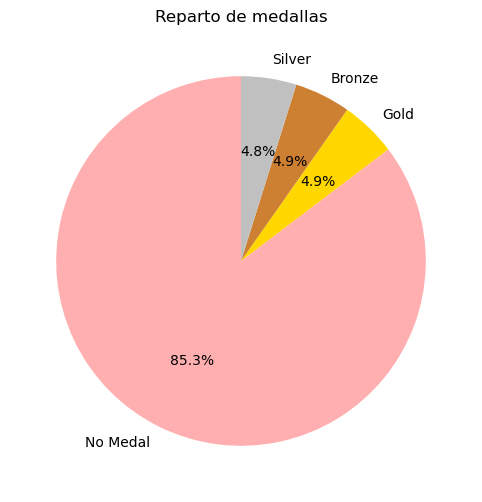

In [41]:
import matplotlib.pyplot as plt

# Contar los valores
total_medallas = df['Medal'].value_counts()

# Graficar pie chart con etiquetas
plt.figure(figsize=(10,6))
total_medallas.plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=["#FFAFAF", "#FFD700", '#CD7F32',  '#C0C0C0'],
    startangle=90
)

plt.title("Reparto de medallas")
plt.ylabel("")
plt.show()

<h3>Edad de los atletas<h3>

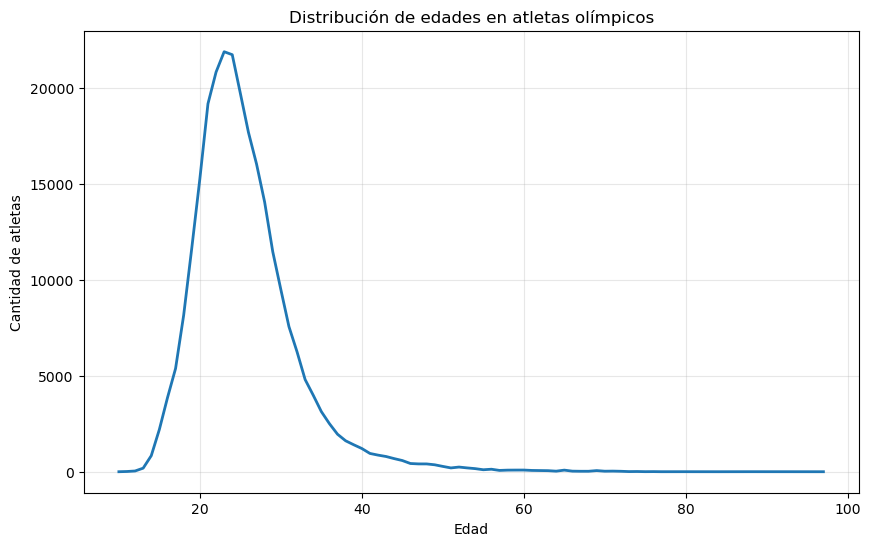

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

edad_atletas = df['Age'].dropna().value_counts().sort_index()

plt.figure(figsize=(10,6))

plt.plot(edad_atletas.index, edad_atletas.values, linewidth=2)

plt.xlabel("Edad")
plt.ylabel("Cantidad de atletas")
plt.title("Distribución de edades en atletas olímpicos")
plt.grid(True, alpha=0.3)

plt.show()

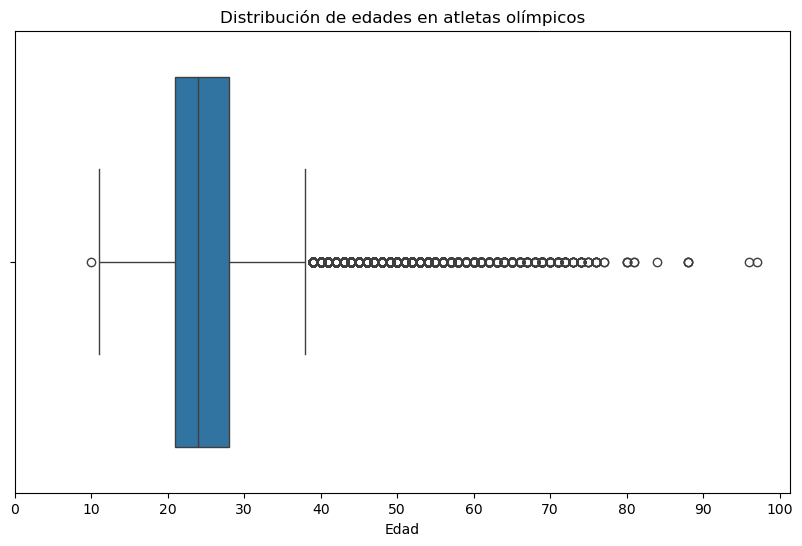


DATOS DESTACABLES:

Media de edad:  25.56
Edad más alta:  97.0
Edad más baja:  10.0


In [43]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df['Age'].dropna())

plt.xticks(range(0, 101, 10))
plt.xlabel("Edad")
plt.title("Distribución de edades en atletas olímpicos")
plt.show()

print("\nDATOS DESTACABLES:\n")
print("Media de edad: ", round(df['Age'].dropna().mean(), 2))
print("Edad más alta: ", df['Age'].dropna().max())
print("Edad más baja: ", df['Age'].dropna().min())

<h3>Deportes con más participación</h3>

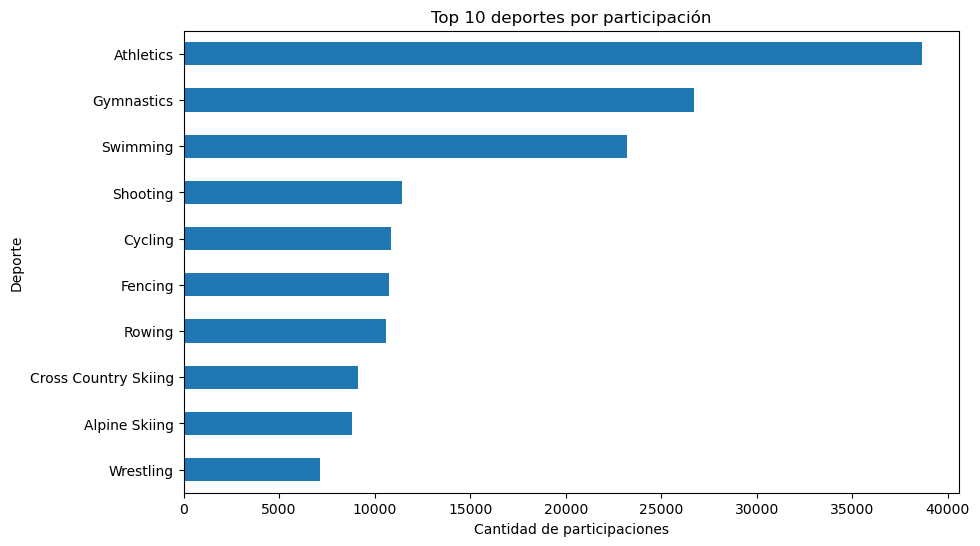

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
df['Sport'].value_counts().head(10).sort_values().plot(kind='barh')

plt.title("Top 10 deportes por participación")
plt.xlabel("Cantidad de participaciones")
plt.ylabel("Deporte")
plt.show()

<h3>Mapa de burbujas por ciudad</h3>

In [45]:
"""import numpy as np
import plotly.express as px
import pandas as pd
from geopy.geocoders import Nominatim
from tqdm import tqdm
import time
from folium.plugins import HeatMap
from IPython.display import display

geolocator = Nominatim(user_agent="geoapi")

def get_coordinates(city):
    try:
        if pd.isna(city):
            return pd.Series({'latitude': None, 'longitude': None})
        location = geolocator.geocode(city)
        time.sleep(1)
        if location:
            return pd.Series({'latitude': location.latitude, 'longitude': location.longitude})
        else:
            return pd.Series({'latitude': None, 'longitude': None})
    except Exception as e:
        print(f"Error con {city}: {e}")
        return pd.Series({'latitude': None, 'longitude': None})


# Obtener coordenadas únicas
tqdm.pandas()
unique_cities = df[['City']].drop_duplicates().reset_index(drop=True)
coords = unique_cities['City'].progress_apply(get_coordinates)
unique_cities = pd.concat([unique_cities, coords], axis=1)

# Unir coordenadas a df original
df = df.merge(unique_cities, on='City', how='left')

# Agrupar por ciudad
df_grouped = df.groupby(['City', 'latitude', 'longitude']).size().reset_index(name='count')

# Crear copia limpia
df_grouped_clean = df_grouped.copy()

# Eliminar ciudades sin coordenadas
df_grouped_clean = df_grouped_clean.dropna(subset=['latitude', 'longitude'])

# Escalar tamaños
df_grouped_clean['size_scaled'] = np.log1p(df_grouped_clean['count'])

# Escala de rojos
red_scale = ["#ffcccc", "#ff6666", "#cc0000"]

# Crear mapa
fig = px.scatter_geo(
    df_grouped_clean,
    lat='latitude',
    lon='longitude',
    size='size_scaled',
    color='count',
    hover_name='City',
    projection='natural earth',
    size_max=15,
    color_continuous_scale=red_scale
)

fig.update_layout(
    title="Mapa de burbujas por ciudad (Escala Logarítmica)",
    geo=dict(
        showland=True,
        landcolor="lightgreen",
        showocean=True,
        oceancolor="lightblue"
    ),
    width=900,
    height=500
)

fig.show()"""


'import numpy as np\nimport plotly.express as px\nimport pandas as pd\nfrom geopy.geocoders import Nominatim\nfrom tqdm import tqdm\nimport time\nfrom folium.plugins import HeatMap\nfrom IPython.display import display\n\ngeolocator = Nominatim(user_agent="geoapi")\n\ndef get_coordinates(city):\n    try:\n        if pd.isna(city):\n            return pd.Series({\'latitude\': None, \'longitude\': None})\n        location = geolocator.geocode(city)\n        time.sleep(1)\n        if location:\n            return pd.Series({\'latitude\': location.latitude, \'longitude\': location.longitude})\n        else:\n            return pd.Series({\'latitude\': None, \'longitude\': None})\n    except Exception as e:\n        print(f"Error con {city}: {e}")\n        return pd.Series({\'latitude\': None, \'longitude\': None})\n\n\n# Obtener coordenadas únicas\ntqdm.pandas()\nunique_cities = df[[\'City\']].drop_duplicates().reset_index(drop=True)\ncoords = unique_cities[\'City\'].progress_apply(get_coor

In [46]:
"""df.drop(columns=["latitude", "longitude"], inplace=True)"""


'df.drop(columns=["latitude", "longitude"], inplace=True)'

<h3>Porcentaje de participación según el sexo</h3>

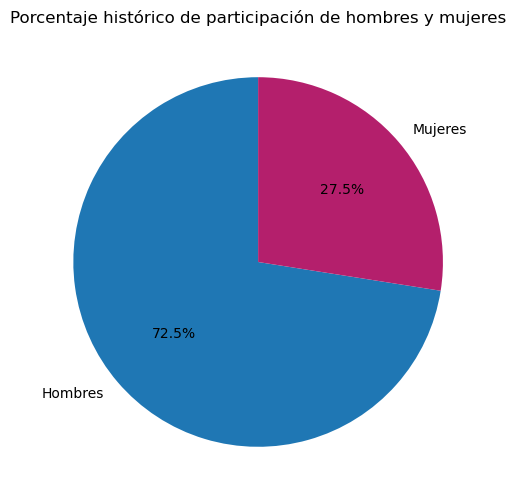

In [47]:
import matplotlib.pyplot as plt

# Mapear los números binarios con sus nombres
sex_map = {'F': 'Mujeres', 'M': 'Hombres'}

# Contar los valores
counts = df['Sex'].value_counts()

# Grafica pie chart
plt.figure(figsize=(10,6))
counts.plot(
    kind='pie',
    labels=[sex_map[i] for i in counts.index],
    autopct='%1.1f%%',
    colors=["#1f77b4", "#b41f6c"],
    startangle=90
)

plt.title("Porcentaje histórico de participación de hombres y mujeres")
plt.ylabel("")  # Eliminar etiqueta
plt.show()

<h1>Análisis multivariante</h1>

<h3>Participación de atletas según el sexo durante los años</h3>

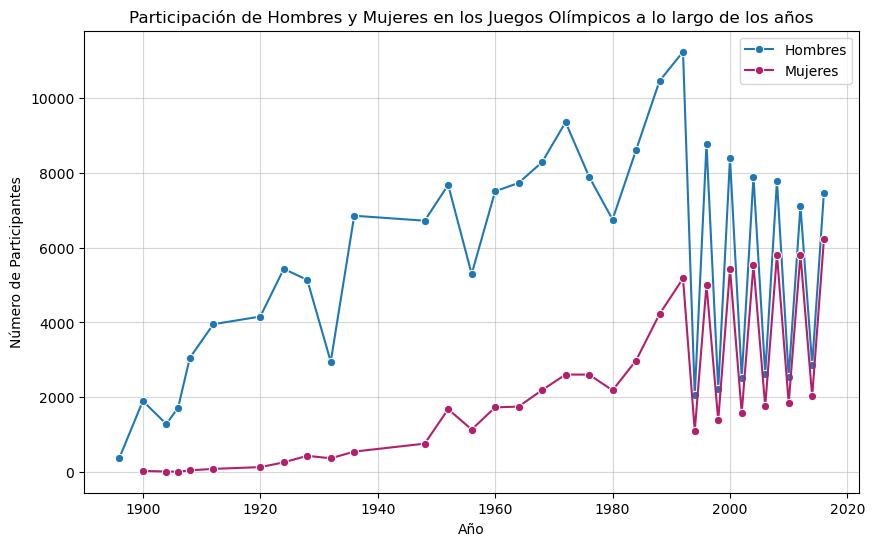

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

participacion = df.groupby(['Year', 'Sex']).size().reset_index(name='Participantes')

# Mapear los números binarios con sus nombres
sex_map = {'F': 'Mujeres', 'M': 'Hombres'}

# Crear columna con el nombre de los sexos a partir del mapeo
participacion['Sexo'] = participacion['Sex'].map(sex_map)

# Gráfica de puntos
plt.figure(figsize=(10,6))
sns.lineplot(
    data=participacion,
    x='Year',
    y='Participantes',
    hue='Sexo',
    marker='o',
    palette=["#1f77b4", "#b41f6c"]
)

# Estilo y etiquetas
plt.title('Participación de Hombres y Mujeres en los Juegos Olímpicos a lo largo de los años')
plt.xlabel('Año')
plt.ylabel('Número de Participantes')
plt.grid(True, alpha=0.5)
plt.legend(title='')
plt.show()

<h3>Reparto de medallas por año</h3>

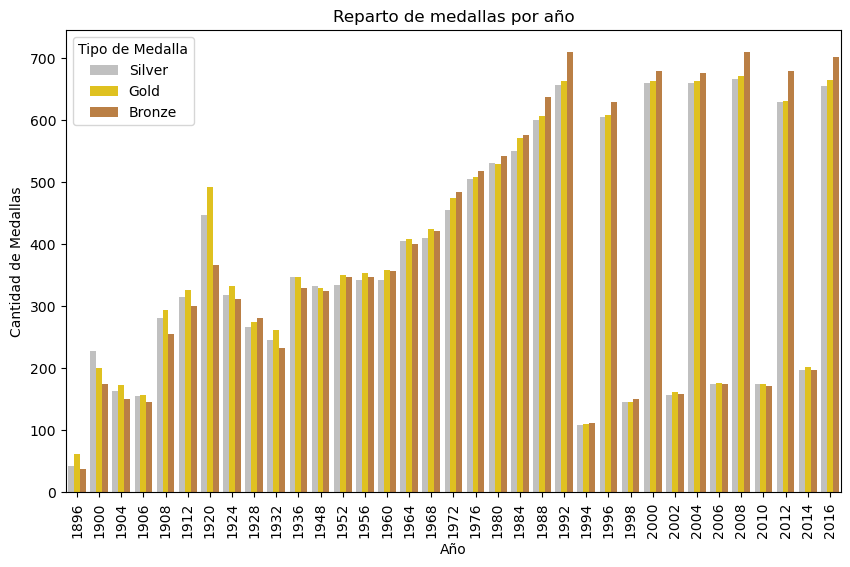

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.countplot(
    x='Year',
    hue='Medal',
    data=df[df['Medal'] != 'No Medal'],
    palette={"Bronze": '#CD7F32', "Silver": '#C0C0C0', "Gold": '#FFD700'}
)

plt.xticks(rotation=90)
plt.title("Reparto de medallas por año")
plt.ylabel("Cantidad de Medallas")
plt.xlabel("Año")
plt.legend(title="Tipo de Medalla")
plt.show()

<h3>Países con más medallas olímpicas</h3>

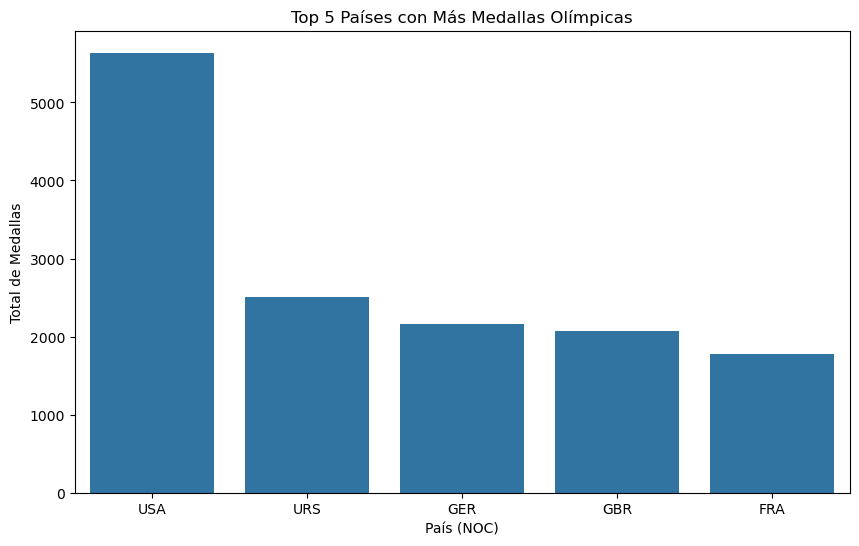

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.countplot(
    data=df[df['Medal'] != 'No Medal'],
    x='NOC',
    order=df[df['Medal'] != 'No Medal']['NOC'].value_counts().head(5).index
)
plt.title('Top 5 Países con Más Medallas Olímpicas')
plt.xlabel('País (NOC)')
plt.ylabel('Total de Medallas')
plt.show()

<h3>Relación entre altura y peso</h3>

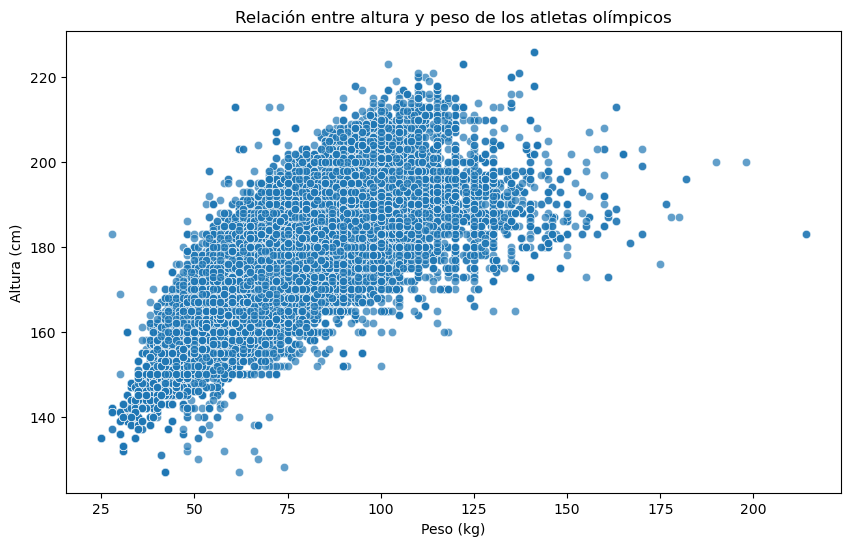

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

df[['Height', 'Weight']] = df[['Height', 'Weight']].dropna()

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x='Weight',
    y='Height',
    alpha=0.7
)

plt.xlabel("Peso (kg)")
plt.ylabel("Altura (cm)")
plt.title("Relación entre altura y peso de los atletas olímpicos")
plt.show()

<h3>Deportes con más participación de mujeres en ediciones de Inverno</h3>

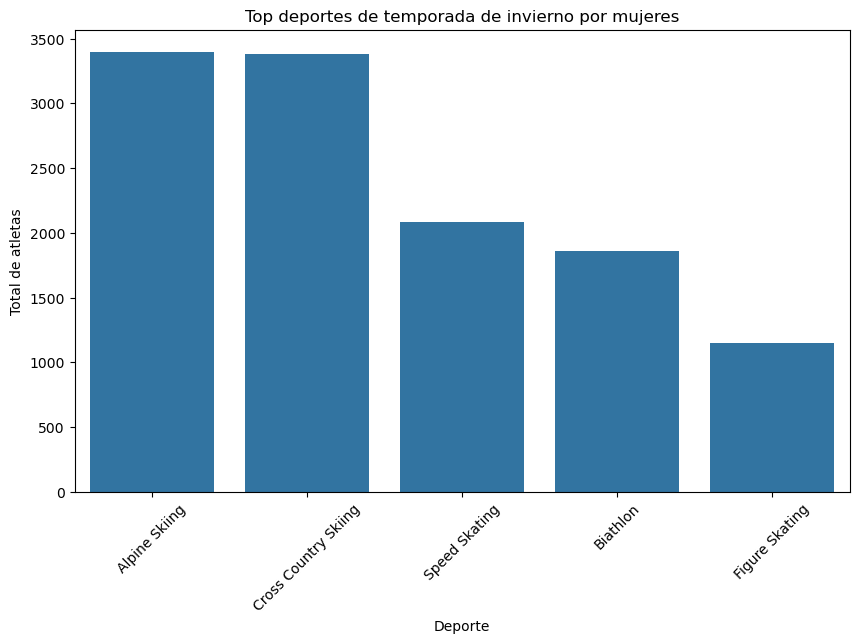

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.countplot(
    data=df[(df['Season'] == 'Winter') & (df['Sex'] == 'F')],
    x='Sport',
    order=df[(df['Season'] == 'Winter') & (df['Sex'] == 'F')]['Sport'].value_counts().head(5).index
)

plt.title('Top deportes de temporada de invierno por mujeres')
plt.xlabel('Deporte')
plt.ylabel('Total de atletas')
plt.xticks(rotation=45)
plt.show()

<h2>Tratamiento de valores NaN</h2

In [53]:
print("Número de filas previas a la eliminación de valores NaN:", len(df))

df = df.dropna(subset=['Height'])
df = df.dropna(subset=['Weight'])
df = df.dropna(subset=['Age'])

print("Número de filas tras eliminar valores NaN:", len(df))

Número de filas previas a la eliminación de valores NaN: 271116
Número de filas tras eliminar valores NaN: 206165


<h3>Codificación de las variables categóricas</h3>

In [54]:
# from sklearn.preprocessing import LabelEncoder

# Se ha usado un "Label Encoder" manual ya que la codificación mediante LabelEncoder()
# se hacía de forma alfabética, lo que nos perjudica si queremos ordenar las medallas
# de peor a mejor resultado (No Medal -> Bronze -> Silver -> Gold)

# Visualizamos los diferentes valores en la columna ['Medal']
print("Valores únicos antes de la codificación:", df['Medal'].unique())

# Realizamos un diccionario con los valores actuales y los numéricos a los que queremos codificar
medal_map = {'No Medal': 0, 'Bronze': 1, 'Silver': 2, 'Gold': 3}

# Codificamos las variables categóricas a numéricas
df['Medal'] = df['Medal'].map(medal_map)

# Comprobar resultado
print("Valores únicos una vez codificacos:", df['Medal'].unique())

# 0 => No Medal
# 1 => Bronze
# 2 => Silver
# 3 => Gold

Valores únicos antes de la codificación: ['No Medal' 'Bronze' 'Gold' 'Silver']
Valores únicos una vez codificacos: [0 1 3 2]


<h3>Binarización</h3>
Se realiza binarización sobre las columnas ['Sex'] y ['Season']

In [55]:
df['Sex_Male'] = (df['Sex'] == "M").astype(int)
df['Season_Winter'] = (df['Season'] == "Winter").astype(int)

print(df[['Sex_Male', 'Season_Winter']].head(1))

df.drop(columns=["Sex", "Season"], inplace=True)

   Sex_Male  Season_Winter
0         1              0


<h3>Escalado</h3>
Se aplica un escalado entre 0 y 1 a las columnas ['Age'], ['Weight'] y ['Height']

In [56]:
from sklearn.preprocessing import MinMaxScaler

sc_age = MinMaxScaler()
sc_weight = MinMaxScaler()
sc_height = MinMaxScaler()

df['Age_scaled'] = sc_age.fit_transform(df[['Age']])
df['Weight_scaled'] = sc_weight.fit_transform(df[['Weight']])
df['Height_scaled'] = sc_height.fit_transform(df[['Height']])


<h3>Mapa de calor relacional</h3>

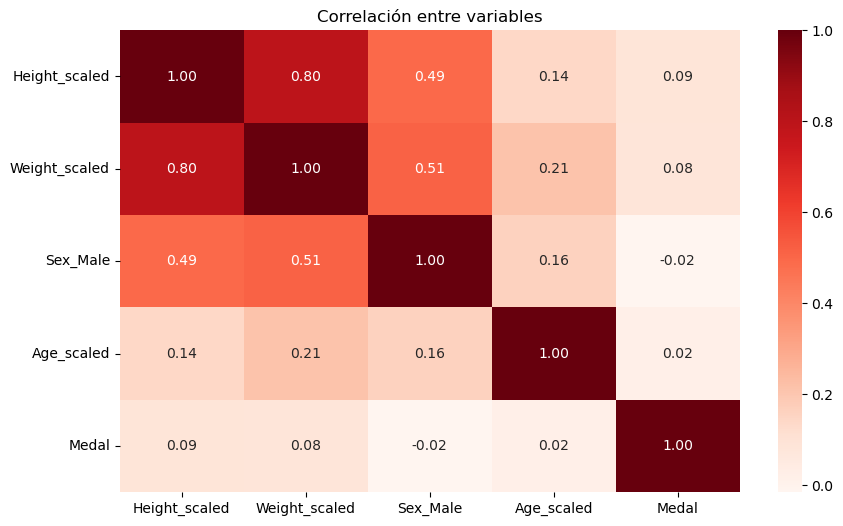

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[['Height_scaled', 'Weight_scaled', 'Sex_Male', 'Age_scaled', 'Medal']].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='Reds', fmt=".2f")
plt.title("Correlación entre variables")
plt.show()

<h2>Resultado de la preparación de datos EDA</h2>

In [58]:
df.head()

,Age,Height,Weight,NOC,Year,City,Sport,Medal,Sex_Male,Season_Winter,Age_scaled,Weight_scaled,Height_scaled
0,24.0,180.0,80.0,CHN,1992,Barcelona,Basketball,0,1,0,0.216667,0.291005,0.535354
1,23.0,170.0,60.0,CHN,2012,London,Judo,0,1,0,0.200000,0.185185,0.434343
4,21.0,185.0,82.0,NED,1988,Calgary,Speed Skating,0,0,1,0.166667,0.301587,0.585859
5,21.0,185.0,82.0,NED,1988,Calgary,Speed Skating,0,0,1,0.166667,0.301587,0.585859
6,25.0,185.0,82.0,NED,1992,Albertville,Speed Skating,0,0,1,0.233333,0.301587,0.585859


## Cambiar las fechas de la Separación de Invierno

In [59]:
df.loc[(df['Year'] > 1990) & (df['Year'] % 4 == 2), 'Year'] = df['Year'] + 2

print("Años que quedan: ", df['Year'].unique())

Años que quedan:  [1992 2012 1988 1996 2004 1980 2000 2016 1948 1952 2008 1984 1968 1972
 1936 1956 1960 1920 1924 1928 1976 1964 1912 1932 1908 1906 1904 1900
 1896]


### Ajuste de tamaño del dataset

In [60]:
# df = df[df['Year'] >= 2000]
df.shape 

(206165, 13)

# PARTE 2: REGRESIÓN

### REGRESIÓN LINEAL SIMPLE (edad/peso)

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = df[['Age_scaled']]
y = df[['Weight_scaled']]

# Modelo
model = LinearRegression()
model.fit(X, y)

# Predicción para una edad nueva
edad_real = 30
edad_escalada = sc_age.transform([[edad_real]])
peso_escalado = model.predict(edad_escalada)
peso_predicho = sc_weight.inverse_transform(peso_escalado)
print("Peso predicho para edad", edad_real, ":", peso_predicho[0][0])

# Evaluación del modelo en escala real
y_pred_scaled = model.predict(X)
y_pred = sc_weight.inverse_transform(y_pred_scaled)
y_real = df[['Weight']].values  # Valores originales

r2 = r2_score(y_real, y_pred) * 100  # R^2 en %
mse = mean_squared_error(y_real, y_pred)
rmse = np.sqrt(mse)

print("R^2 (%):", r2)
print("RMSE: (kg)", rmse)



Peso predicho para edad 30 : 73.43038096525906
R^2 (%): 4.496126758875107
RMSE: (kg) 14.01421656840299


### REGRESIÓN LINEAL SIMPLE (peso/altura)

Peso predicho para estatura 170 cm: 64.87374562242792 kg
R^2 (%): 63.538672519365605
RMSE (kg): 8.672571916420972


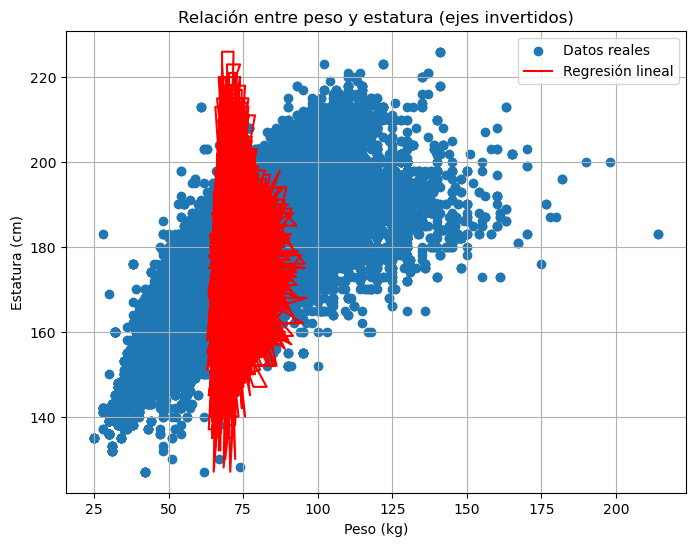

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Variables: X = Estatura escalada, y = Peso escalado
X = df[['Height_scaled']]
y = df[['Weight_scaled']]

# Dividir datos en entrenamiento y prueba (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Modelo
modelo = LinearRegression()

# Entrenamiento
modelo.fit(X_train, y_train)

# Predicción para una estatura nueva
estatura_real = 170  # por ejemplo, 170 cm
estatura_escalada = sc_height.transform([[estatura_real]])
peso_escalado = modelo.predict(estatura_escalada)
peso_predicho = sc_weight.inverse_transform(peso_escalado)

print("Peso predicho para estatura", estatura_real, "cm:", peso_predicho[0][0], "kg")

# Evaluación del modelo en escala real
y_pred_test_escalado = modelo.predict(X_test)
y_test_real = sc_weight.inverse_transform(y_test)
y_pred_test = sc_weight.inverse_transform(y_pred_test_escalado)
y_real = df[['Weight']].values  # valores reales originales

r2 = r2_score(y_test_real, y_pred_test) * 100  # R^2 en porcentaje
mse = mean_squared_error(y_test_real, y_pred_test)
rmse = np.sqrt(mse)

print("R^2 (%):", r2)
print("RMSE (kg):", rmse)

x_real = df[['Height']].values

plt.figure(figsize=(8,6))

# Datos reales (Weight en X, Height en Y)
plt.scatter(y_real, x_real, label="Datos reales")

# Línea de regresión (también invertida)
plt.plot(y_pred, x_real, color='red', label="Regresión lineal")

plt.xlabel("Peso (kg)")
plt.ylabel("Estatura (cm)")
plt.title("Relación entre peso y estatura (ejes invertidos)")
plt.legend()
plt.grid(True)
plt.show()


### REGRESION POLINÓMICA

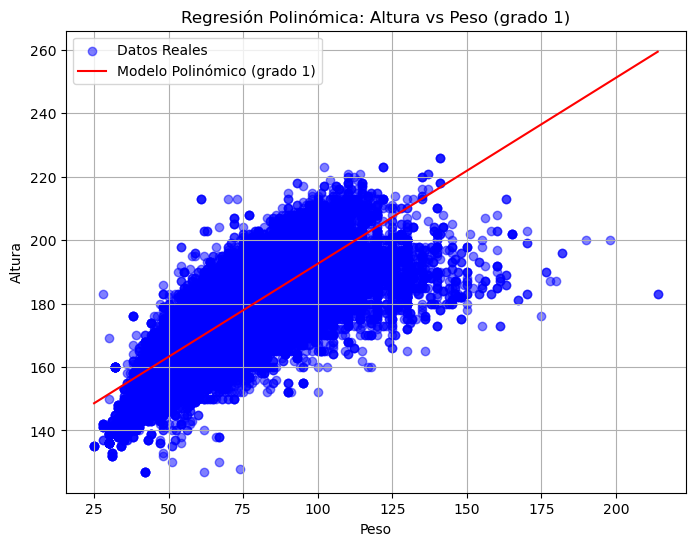

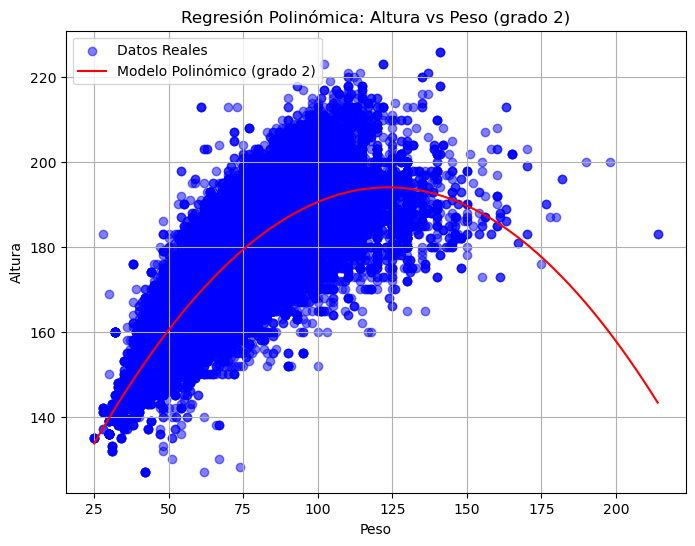

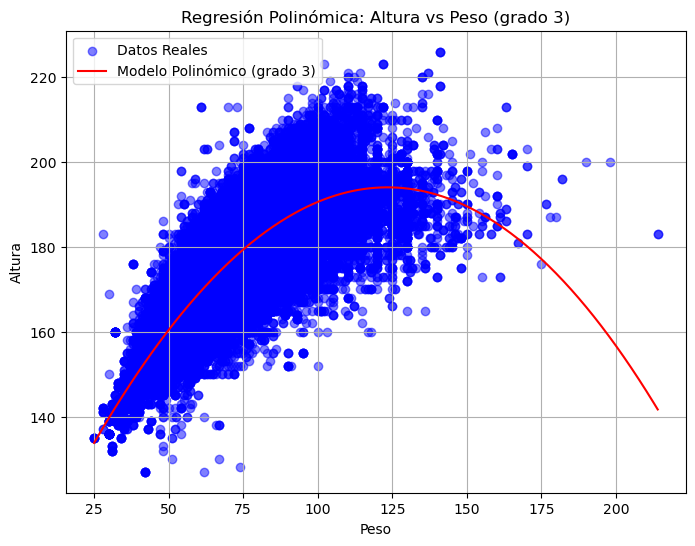

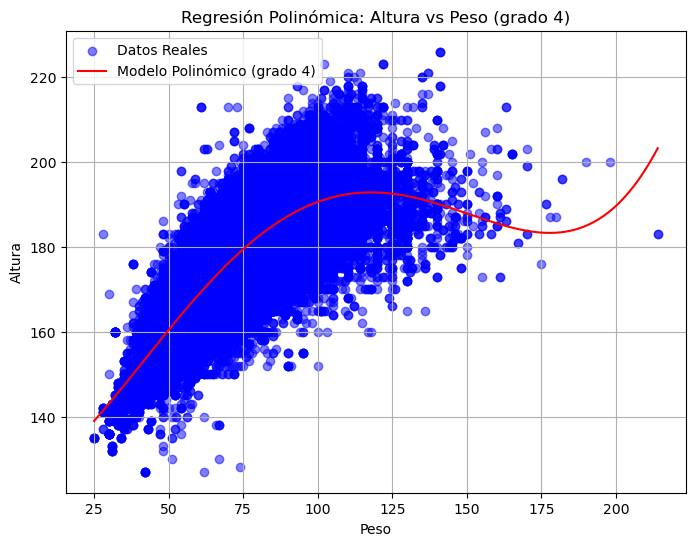

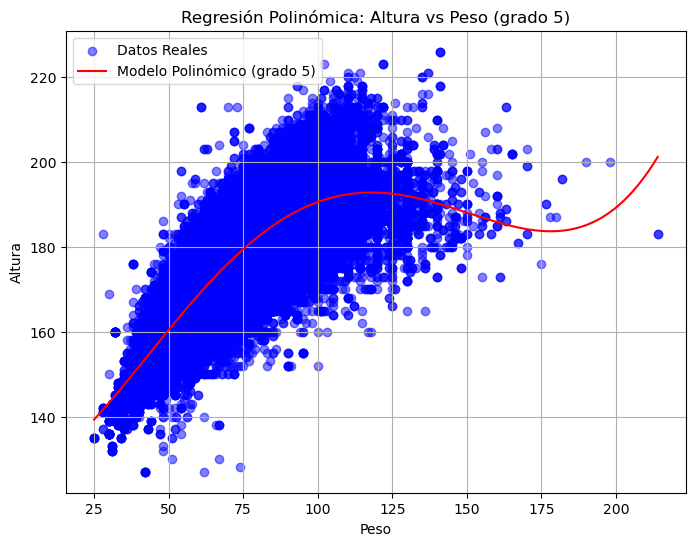


Resultados de los modelos de regresión polinómica (ordenados por R²):
 Degree      MSE     RMSE       R²
      4 0.003531 0.059418 0.687180
      5 0.003531 0.059419 0.687172
      2 0.003542 0.059511 0.686205
      3 0.003542 0.059511 0.686204
      1 0.004115 0.064148 0.635398


In [63]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

X_scaled = df[['Weight_scaled']]   # Edad escalada
y_scaled = df[['Height_scaled']]   # Peso escalado

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# Guardar los min y max para desescalar luego
height_min, height_max = df['Height'].min(), df['Height'].max()
weight_min, weight_max = df['Weight'].min(), df['Weight'].max()

# -------------------------------------
# Loop para probar diferentes grados
# -------------------------------------
degrees = [1, 2, 3, 4, 5]
results = []

for degree in degrees:
    # Transformar características
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Entrenar modelo
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # Predicciones (escaladas)
    y_pred_scaled = model.predict(X_test_poly)

    # Métricas en escala
    mse = mean_squared_error(y_test, y_pred_scaled)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred_scaled)
    results.append((degree, mse, rmse, r2))

    # ---------------------------
    # Graficar resultados en valores reales
    # ---------------------------
    # Desescalar X y predicciones
    X_range_scaled = np.linspace(0, 1, 300).reshape(-1, 1)
    X_range_poly = poly.transform(X_range_scaled)
    y_range_pred_scaled = model.predict(X_range_poly)

    # Convertir a valores reales
    X_range_real = X_range_scaled * (weight_max - weight_min) + weight_min
    y_range_pred_real = y_range_pred_scaled * (height_max - height_min) + height_min

    plt.figure(figsize=(8,6))
    # Datos reales en valores reales
    plt.scatter(df['Weight'], df['Height'], color='blue', alpha=0.5, label="Datos Reales")
    # Predicciones del modelo
    plt.plot(X_range_real, y_range_pred_real, color='red', label=f"Modelo Polinómico (grado {degree})")
    plt.xlabel("Peso")
    plt.ylabel("Altura")
    plt.title(f"Regresión Polinómica: Altura vs Peso (grado {degree})")
    plt.legend()
    plt.grid()
    plt.show()

# -------------------------------------
# Resultados en tabla
# -------------------------------------
results_df = pd.DataFrame(results, columns=["Degree", "MSE", "RMSE", "R²"]).sort_values(by="R²", ascending=False)
print("\nResultados de los modelos de regresión polinómica (ordenados por R²):")
print(results_df.to_string(index=False))

### SGD (Stochastic Gradient Descent) (1 variable)

In [64]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# =============================================
# 1. Selección de variables (tu dataset real)
# =============================================
X = df[['Height_scaled']].values        # Edad escalada
y = df[['Weight_scaled']].values.ravel()   # Peso escalado (1D)

# =============================================
# 2. Dividir en entrenamiento / prueba
# =============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =============================================
# 3. Probar varios grados polinómicos usando SGD
# =============================================
degrees = [1, 2, 3, 4, 5]
results = []

for degree in degrees:
    
    # Expandir características polinómicas
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    poly_scaler = StandardScaler()
    X_train_poly_scaled = poly_scaler.fit_transform(X_train_poly)
    X_test_poly_scaled = poly_scaler.transform(X_test_poly)


    # Modelo con SGD
    model = SGDRegressor(
        max_iter=5000,
        learning_rate="adaptive",
        eta0=0.001,
        penalty="l2",
        alpha=0.0001,
        random_state=42
    )

    # Entrenar modelo
    model.fit(X_train_poly_scaled, y_train)

    # Predicciones
    y_pred = model.predict(X_test_poly_scaled)

    # Métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Guardar resultados
    results.append((degree, mse, rmse, r2))

    # ================================
    # 4. Graficar datos y curva polinómica
    # ================================
    X_range = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
    X_range_poly = poly.transform(X_range)
    X_range_poly_scaled = poly_scaler.transform(X_range_poly)
    y_range_pred = model.predict(X_range_poly_scaled)

    X_range_orig = sc_height.inverse_transform(X_range)
    y_range_pred_orig = sc_weight.inverse_transform(y_range_pred.reshape(-1,1))
    X_orig = sc_height.inverse_transform(X)
    y_orig = sc_weight.inverse_transform(y.reshape(-1,1))

    plt.figure(figsize=(8,6))
    plt.scatter(y_orig,X_orig , color='blue', alpha=0.5, label='Datos reales')
    plt.plot(y_range_pred_orig,X_range_orig , color='red', label=f'Polinomio grado {degree}')
    plt.title(f'Regresión polinómica con SGD (grado {degree})')
    plt.xlabel('Peso')
    plt.ylabel('Altura')
    plt.legend()
    plt.grid(True)
    plt.show()

# =============================================
# 5. Mostrar tabla de resultados ordenada por R²
# =============================================
results_df = pd.DataFrame(results, columns=["Degree", "MSE", "RMSE", "R²"])
results_df = results_df.sort_values(by="R²", ascending=False)

print("\nResultados de modelos polinómicos con SGD (ordenados por R²):")
print(results_df.to_string(index=False))


NameError: name 'StandardScaler' is not defined

### SGD (Stochastic Gradient Descent) (Multivariable)

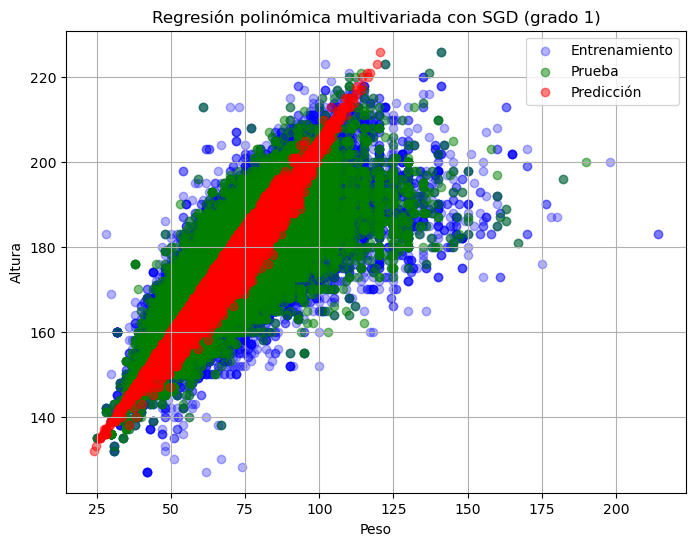

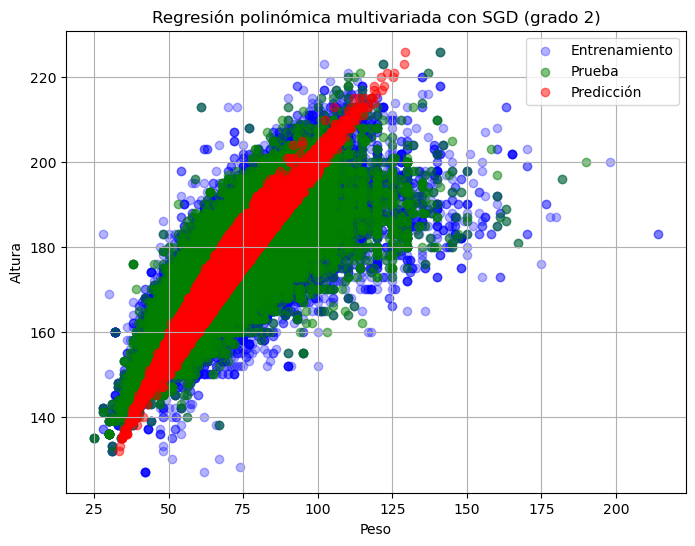

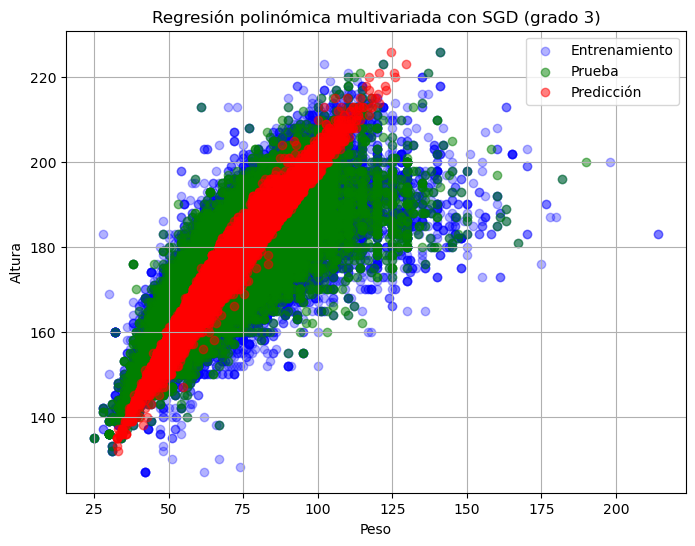

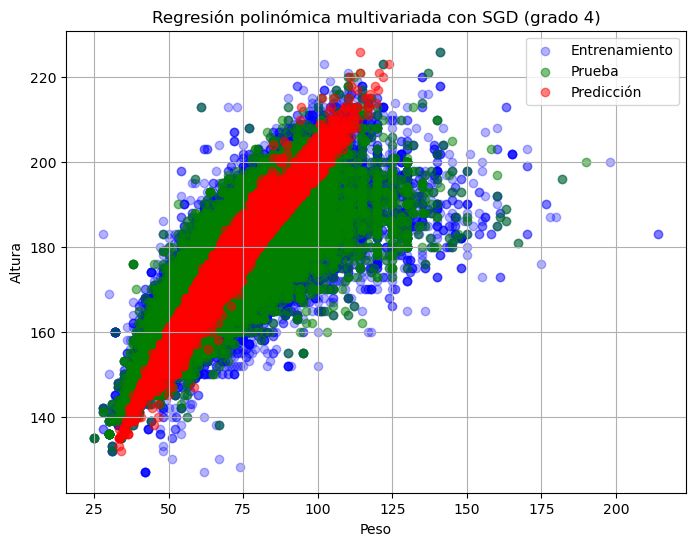

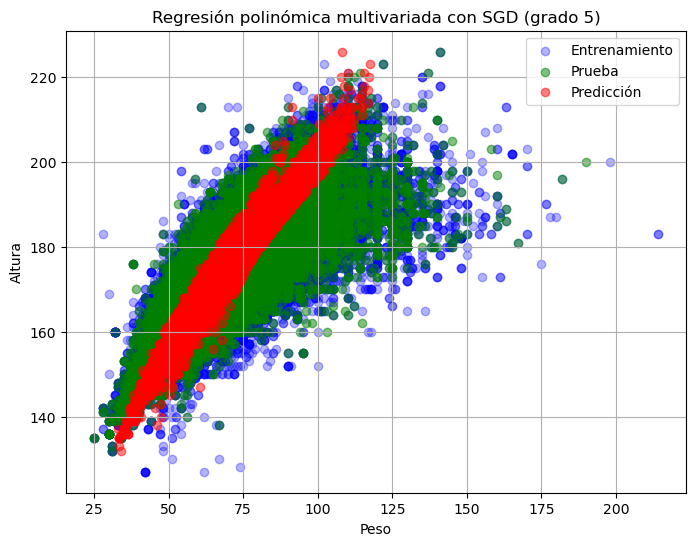


Resultados de modelos polinómicos con SGD (ordenados por R²):
 Degree      MSE     RMSE       R²
      5 0.001905 0.043646 0.670129
      4 0.001905 0.043652 0.670039
      3 0.001907 0.043671 0.669740
      2 0.001912 0.043729 0.668874
      1 0.001942 0.044065 0.663755


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# =============================================

# 1. Selección de variables predictoras

# =============================================

feature_cols = ['Height_scaled', 'Age_scaled', 'Sex_Male']  # variables predictoras
X = df[feature_cols].values
y = df['Weight_scaled'].values  # target 1D

# =============================================

# 2. Dividir en entrenamiento / prueba

# =============================================

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42
)

# =============================================

# 3. Probar varios grados polinómicos usando SGD

# =============================================

degrees = [1, 2, 3, 4, 5]
results = []

for degree in degrees:

    # Expandir características polinómicas
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Escalado
    scaler = StandardScaler()
    X_train_poly_scaled = scaler.fit_transform(X_train_poly)
    X_test_poly_scaled = scaler.transform(X_test_poly)

    # Modelo SGD
    model = SGDRegressor(
        max_iter=5000,
        learning_rate="adaptive",
        eta0=0.001,
        penalty="l2",
        alpha=0.0001,
        random_state=42
    )

    # Entrenar modelo
    model.fit(X_train_poly_scaled, y_train)

    # Predicciones
    y_pred = model.predict(X_test_poly_scaled)

    # Métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Guardar resultados
    results.append((degree, mse, rmse, r2))

    # ================================
    # Graficar datos desescalados
    # ================================
    # Desescalar peso
    y_pred_orig = sc_weight.inverse_transform(y_pred.reshape(-1,1)).ravel()
    y_test_orig = sc_weight.inverse_transform(y_test.reshape(-1,1)).ravel()
    # Desescalar altura
    X_test_height_orig = sc_height.inverse_transform(X_test[:,0].reshape(-1,1)).ravel()
    X_train_height_orig = sc_height.inverse_transform(X_train[:,0].reshape(-1,1)).ravel()

    plt.figure(figsize=(8,6))
    plt.scatter(sc_weight.inverse_transform(y_train.reshape(-1,1)), X_train_height_orig,
            color='blue', alpha=0.3, label='Entrenamiento')
    plt.scatter(y_test_orig, X_test_height_orig, color='green', alpha=0.5, label='Prueba')
    plt.scatter(y_pred_orig, X_test_height_orig, color='red', alpha=0.5, label='Predicción')
    plt.xlabel('Peso')
    plt.ylabel('Altura')
    plt.title(f'Regresión polinómica multivariada con SGD (grado {degree})')
    plt.legend()
    plt.grid(True)
    plt.show()

# =============================================

# 4. Mostrar tabla de resultados ordenada por R²

# =============================================

results_df = pd.DataFrame(results, columns=["Degree", "MSE", "RMSE", "R²"])
results_df = results_df.sort_values(by="R²", ascending=False)

print("\nResultados de modelos polinómicos con SGD (ordenados por R²):")
print(results_df.to_string(index=False))


### REGRESIÓN LINEAL MÚLTIPLE

Resultados regresión lineal múltiple:
MSE: 72.86677841357621
RMSE: 8.53620398148827
R²: 0.6467629692244231


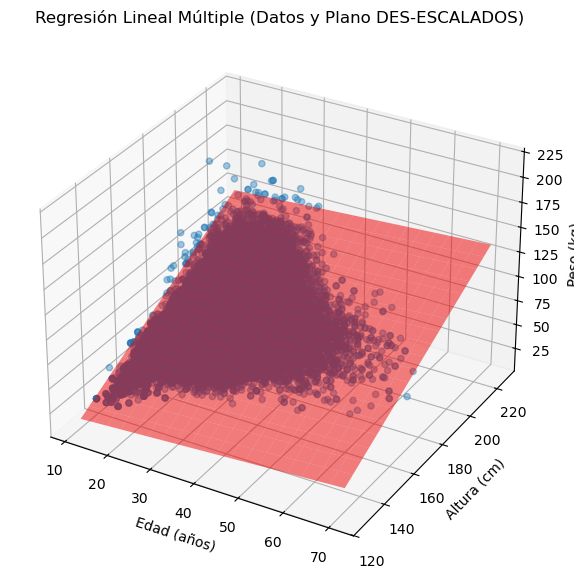

In [ ]:
# ============================================
# IMPORTAR LIBRERÍAS
# ============================================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# ============================================
# SELECCIÓN DE VARIABLES
# ============================================
X = df[['Age_scaled', 'Height_scaled']]
y = df['Weight']   # peso real (kg)

# ============================================
# DIVISIÓN TRAIN/TEST
# ============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============================================
# MODELO
# ============================================
model = LinearRegression()
model.fit(X_train, y_train)

# Predicción
y_pred = model.predict(X_test)

# ============================================
# MÉTRICAS
# ============================================
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Resultados regresión lineal múltiple:")
print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)

# ============================================
# GRAFICAR EN 3D (TODO DESESCALADO)
# ============================================
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# ================================
# 1) Desescalar valores reales
# ================================
age_real_train   = sc_age.inverse_transform(X_train[['Age_scaled']]).ravel()
height_real_train = sc_height.inverse_transform(X_train[['Height_scaled']]).ravel()

# Graficar puntos reales desescalados
ax.scatter(
    age_real_train, 
    height_real_train, 
    y_train,
    alpha=0.4,
    label='Datos reales'
)

# ================================
# 2) Crear malla desescalada
# ================================
age_scaled_grid, height_scaled_grid = np.meshgrid(
    np.linspace(X['Age_scaled'].min(), X['Age_scaled'].max(), 20),
    np.linspace(X['Height_scaled'].min(), X['Height_scaled'].max(), 20)
)

# Predicciones del modelo (aún en escala del modelo)
predicted_weight_grid = model.predict(
    np.c_[age_scaled_grid.ravel(), height_scaled_grid.ravel()]
).reshape(age_scaled_grid.shape)

# Convertir la malla a valores reales
age_real_grid = sc_age.inverse_transform(age_scaled_grid)
height_real_grid = sc_height.inverse_transform(height_scaled_grid)

# ================================
# 3) Graficar plano desescalado
# ================================
ax.plot_surface(
    age_real_grid, 
    height_real_grid, 
    predicted_weight_grid,
    alpha=0.5, 
    color='red'
)

# Etiquetas finales desescaladas
ax.set_xlabel('Edad (años)')
ax.set_ylabel('Altura (cm)')
ax.set_zlabel('Peso (kg)')
ax.set_title('Regresión Lineal Múltiple (Datos y Plano DES-ESCALADOS)')

plt.show()


### OTROS MODELOS LINEALES

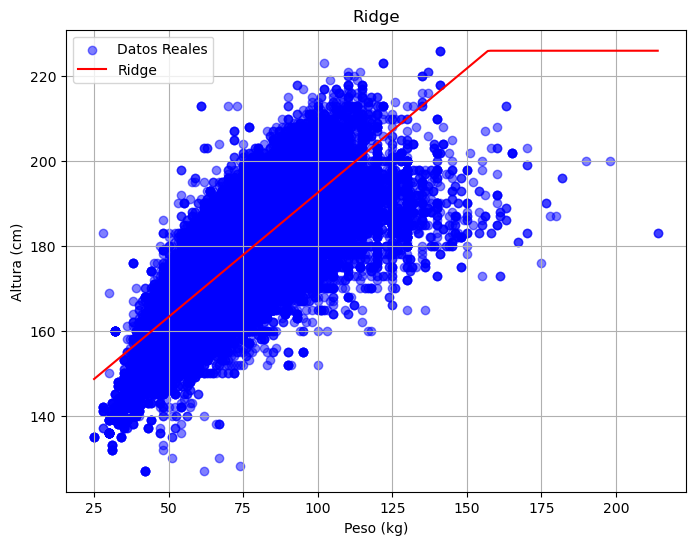

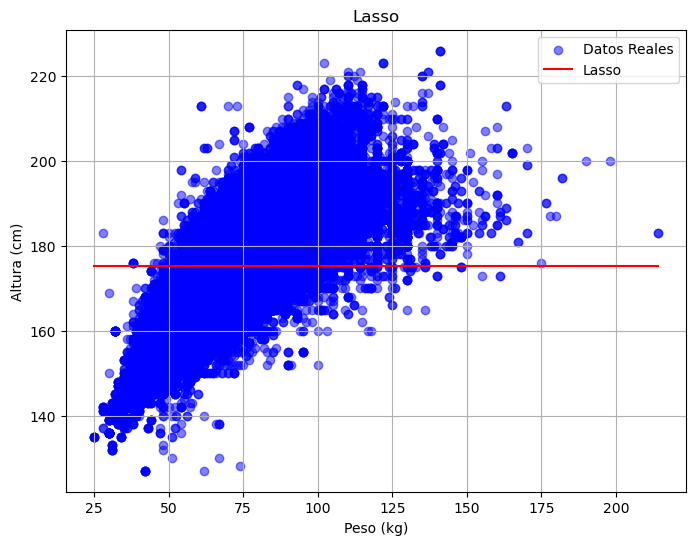

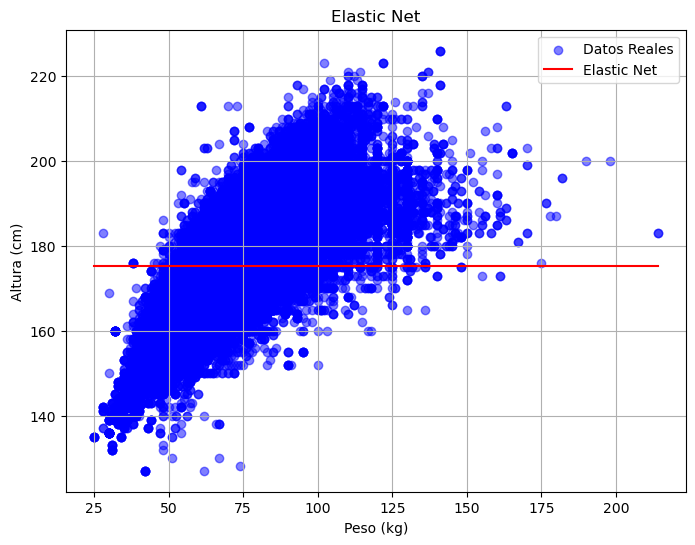

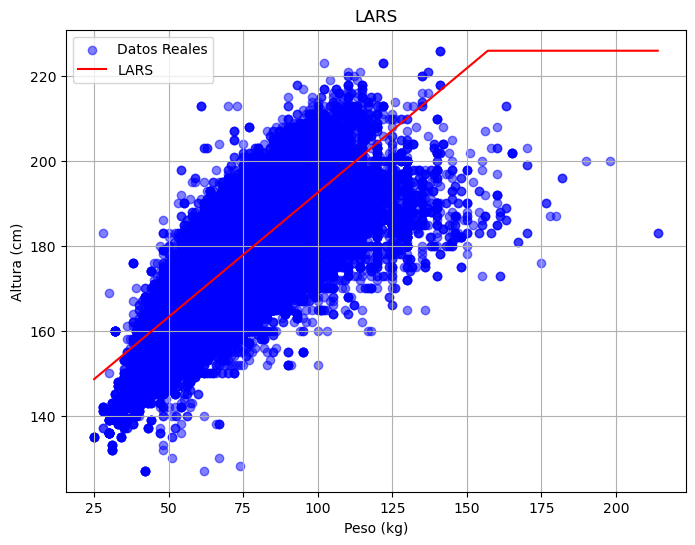

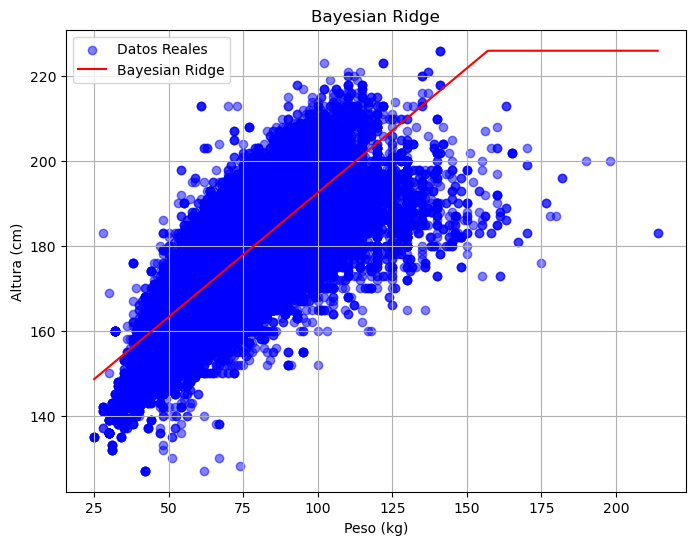

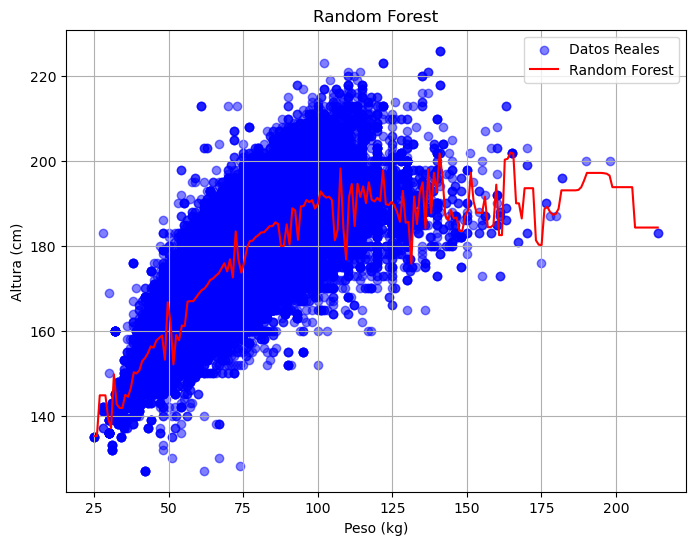


Resultados de los modelos de regresión (ordenados por R²):
        Modelo      MSE     RMSE       R²
 Random Forest 0.003503 0.059185 0.689638
         Ridge 0.004115 0.064148 0.635404
Bayesian Ridge 0.004115 0.064148 0.635398
          LARS 0.004115 0.064148 0.635398
         Lasso 0.011286 0.106237 0.000000
   Elastic Net 0.011286 0.106237 0.000000


In [ ]:
# Importar librerías
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet, Lars, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ---------------------------------------------
# 1. Selección de variables
# ---------------------------------------------
X = df[['Weight_scaled']]
y = df[['Height_scaled']]

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Guardar min/max para desescalar luego
height_min, height_max = df['Height'].min(), df['Height'].max()
weight_min, weight_max = df['Weight'].min(), df['Weight'].max()

# ---------------------------------------------
# 2. Modelos a evaluar
# ---------------------------------------------
models = {
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "Elastic Net": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "LARS": Lars(),
    "Bayesian Ridge": BayesianRidge(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
}

results = []

# ---------------------------------------------
# 3. Entrenamiento y evaluación
# ---------------------------------------------
for name, model in models.items():

    # Entrenar modelo
    model.fit(X_train, y_train.values.ravel())

    # Predecir (en escala)
    y_pred_scaled = model.predict(X_test)

    # Métricas
    mse = mean_squared_error(y_test, y_pred_scaled)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred_scaled)

    results.append((name, mse, rmse, r2))

    # -----------------------------------------
    # 4. Graficar en valores reales 
    # -----------------------------------------

    X_range_scaled = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
    y_range_scaled = model.predict(X_range_scaled)

    # Limitar predicciones para evitar explosiones
    y_range_scaled = np.clip(y_range_scaled, 0, 1)

    # Desescalar valores reales
    X_range_real = X_range_scaled * (weight_max - weight_min) + weight_min
    y_range_real = y_range_scaled * (height_max - height_min) + height_min

    plt.figure(figsize=(8, 6))
    plt.scatter(df['Weight'], df['Height'], color="blue", alpha=0.5, label="Datos Reales")
    plt.plot(X_range_real, y_range_real, color="red", label=name)
    plt.xlabel("Peso (kg)")
    plt.ylabel("Altura (cm)")
    plt.title(name)
    plt.legend()
    plt.grid()
    plt.show()

# ---------------------------------------------
# 5. Resultados ordenados por desempeño
# ---------------------------------------------
results_df = pd.DataFrame(results, columns=["Modelo", "MSE", "RMSE", "R²"])
results_df = results_df.sort_values(by="R²", ascending=False)
results_df['R²'] = results_df['R²'].apply(lambda v: 0 if v < 0 else v)
results_df = results_df.round(6)

print("\nResultados de los modelos de regresión (ordenados por R²):")
print(results_df.to_string(index=False))

### SVM (SUPPORT VECTOR REGRESSION)

In [ ]:
# Código comentado porque tarda 60 minutos en compilar
# Descomentar cuando se vaya a realizar la última compilación

"""
# ============================================
# IMPORTAR LIBRERÍAS
# ============================================
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# ============================================
# CARGAR TU DATASET
# ============================================

# Usamos las columnas ya escaladas
X = df[['Weight_scaled']]
y = df['Height_scaled']

# ============================================
# DIVISIÓN TRAIN / TEST
# ============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============================================
# DEFINIR MODELOS SVR
# ============================================
models = {
    "SVR Lineal": SVR(kernel="linear", C=1.0),
    "SVR RBF": SVR(kernel="rbf", C=1.0, gamma=0.1)
}

results = []

# ============================================
# ENTRENAR Y EVALUAR MODELOS
# ============================================
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append((name, mse, rmse, r2))

results_df = pd.DataFrame(results, columns=["Modelo", "MSE", "RMSE", "R²"])
results_df = results_df.sort_values(by="R²", ascending=False)
print(results_df)

# ============================================
# ENTRENAR MODELO FINAL PARA EL GRAFICO
# ============================================
model = models["SVR RBF"]

# ============================================
# DES-ESCALADO AUTOMÁTICO (asumiendo Min-Max scaling)
# ============================================

# Valores originales
weight_min = df["Weight"].min()
weight_max = df["Weight"].max()

height_min = df["Height"].min()
height_max = df["Height"].max()

# Funciones de desescalado
def inv_scale_weight(x):
    return x * (weight_max - weight_min) + weight_min

def inv_scale_height(x):
    return x * (height_max - height_min) + height_min


# ============================================
# GRAFICO SVR CON VALORES REALES
# ============================================
import matplotlib.pyplot as plt

# Ordenar valores escalados
X_plot_scaled = np.sort(X_train.values.reshape(-1))
y_plot_scaled = model.predict(X_plot_scaled.reshape(-1, 1))

# Convertir a valores reales
X_plot_real = inv_scale_weight(X_plot_scaled)
y_plot_real = inv_scale_height(y_plot_scaled)

X_train_real = inv_scale_weight(X_train.values.reshape(-1))
y_train_real = inv_scale_height(y_train.values.reshape(-1))

plt.figure(figsize=(10, 6))

# Datos reales
plt.scatter(X_train_real, y_train_real, s=10, alpha=0.3, label="Datos reales")

# Curva aprendida
plt.plot(X_plot_real, y_plot_real, linewidth=3, color="red", label="SVR RBF")

plt.xlabel("Weight (real)")
plt.ylabel("Height (real)")
plt.title("Regresión SVR — Peso vs Altura (Desescalado)")
plt.legend()
plt.grid(True)
plt.show()
"""

'\n# ============================================\n# IMPORTAR LIBRERÍAS\n# ============================================\nimport numpy as np\nimport pandas as pd\nfrom sklearn.svm import SVR\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import mean_squared_error, r2_score\n\n# ============================================\n# CARGAR TU DATASET\n# ============================================\n\n# Usamos las columnas ya escaladas\nX = df[[\'Weight_scaled\']]\ny = df[\'Height_scaled\']\n\n# ============================================\n# DIVISIÓN TRAIN / TEST\n# ============================================\nX_train, X_test, y_train, y_test = train_test_split(\n    X, y, test_size=0.2, random_state=42\n)\n\n# ============================================\n# DEFINIR MODELOS SVR\n# ============================================\nmodels = {\n    "SVR Lineal": SVR(kernel="linear", C=1.0),\n    "SVR RBF": SVR(kernel="rbf", C=1.0, gamma=0.1)\n}\n\nresults = []\n\n# ======

### ENSEMBLE METHODS

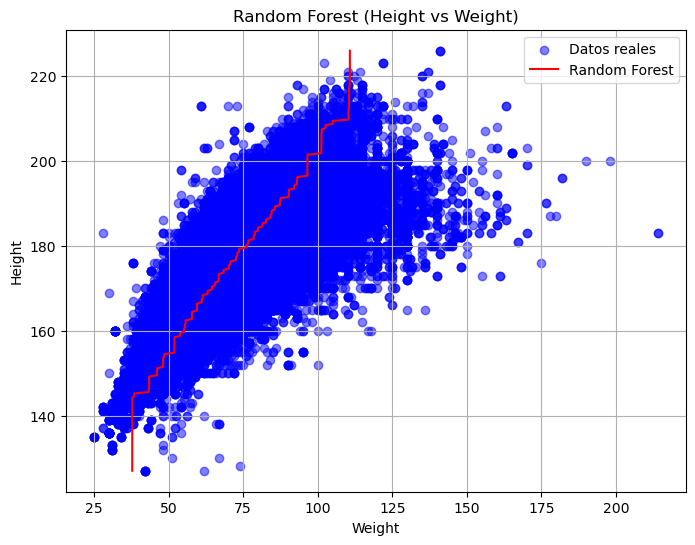

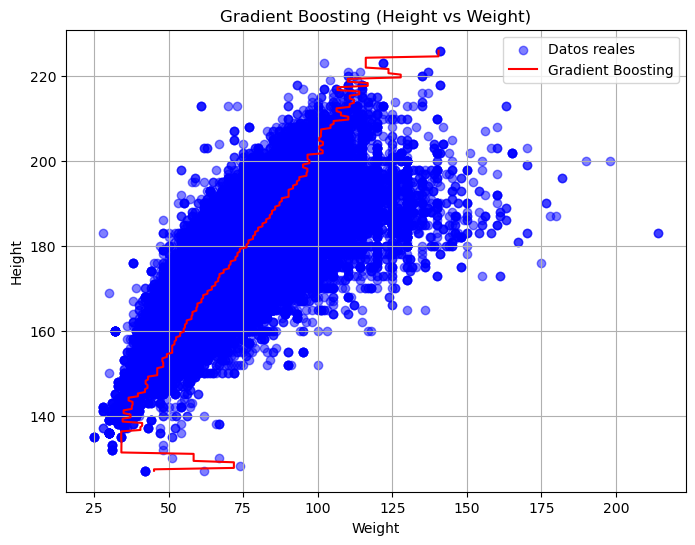

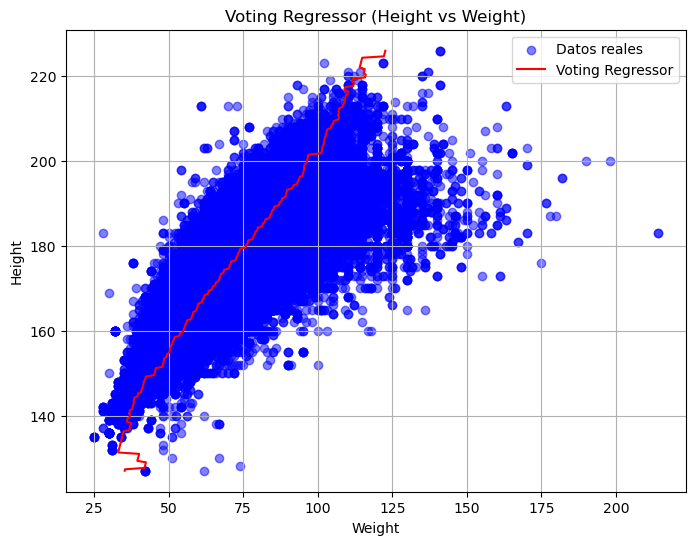


Resultados de modelos ensemble con Height (ordenados por R²):
           Modelo      MSE     RMSE       R²
Gradient Boosting 0.363620 0.603009 0.637506
    Random Forest 0.364072 0.603384 0.637056
 Voting Regressor 0.364087 0.603396 0.637041


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Modelos ensemble
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression

# =============================================
# 0. Escalado de variables
# =============================================
sc_height = StandardScaler()
sc_weight = StandardScaler()

X_scaled = sc_height.fit_transform(df[['Height']].values)  # altura
y_scaled = sc_weight.fit_transform(df[['Weight']].values).ravel()  # peso

X = X_scaled
y = y_scaled

# =============================================
# 1. Dividir en entrenamiento / prueba
# =============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =============================================
# 2. Definir modelos ensemble
# =============================================
models = {
    "Random Forest": RandomForestRegressor(
        n_estimators=200, max_depth=5, random_state=42
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42
    ),
    "Voting Regressor": VotingRegressor([
        ('lr', LinearRegression()),
        ('rf', RandomForestRegressor(n_estimators=100, max_depth=4, random_state=42)),
        ('gb', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
    ])
}

results = []

# =============================================
# 3. Entrenar y evaluar cada modelo
# =============================================
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_scaled = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred_scaled)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred_scaled)
    results.append((name, mse, rmse, r2))
    
    # Graficar predicciones vs datos reales
    X_range = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
    y_range_pred_scaled = model.predict(X_range)
    
    X_range_orig = sc_height.inverse_transform(X_range)
    y_range_pred_orig = sc_weight.inverse_transform(y_range_pred_scaled.reshape(-1,1))
    X_orig = sc_height.inverse_transform(X)
    y_orig = sc_weight.inverse_transform(y.reshape(-1,1))
    
    plt.figure(figsize=(8,6))
    plt.scatter(y_orig, X_orig, color='blue', alpha=0.5, label='Datos reales')
    plt.plot(y_range_pred_orig, X_range_orig, color='red', label=f'{name}')
    plt.title(f'{name} (Altura vs Peso)')
    plt.xlabel('Peso')
    plt.ylabel('Altura')
    plt.legend()
    plt.grid(True)
    plt.show()

# =============================================
# 4. Mostrar tabla de resultados
# =============================================
results_df = pd.DataFrame(results, columns=["Modelo", "MSE", "RMSE", "R²"])
results_df = results_df.sort_values(by="R²", ascending=False)

print("\nResultados de modelos ensemble con Height (ordenados por R²):")
print(results_df.to_string(index=False))


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# ==========================
# ORDENAR POR AÑO
# ==========================
df = df.sort_values("Year")  # asegúrate de que está ordenado

X = df[['Age_scaled', 'Height_scaled']].values
y = df['Weight'].values

# ==========================
# CONFIGURAR TIME SERIES SPLIT
# ==========================
tscv = TimeSeriesSplit(n_splits=5)

print("Validación cruzada temporal con regresión lineal múltiple:")
print("============================================================")

fold_results = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    fold_results.append((fold, mse, rmse, r2))

    print(f"Fold {fold} | MSE={mse:.5f} | RMSE={rmse:.5f} | R2={r2:.5f}")



Validación cruzada temporal con regresión lineal múltiple:
Fold 1 | MSE=64.23109 | RMSE=8.01443 | R2=0.66288
Fold 2 | MSE=69.06111 | RMSE=8.31030 | R2=0.66022
Fold 3 | MSE=79.40748 | RMSE=8.91109 | R2=0.65788
Fold 4 | MSE=85.50417 | RMSE=9.24685 | R2=0.63319
Fold 5 | MSE=86.08786 | RMSE=9.27835 | R2=0.62493
